# Implementación algoritmo Montecarlo en robótica móvil

## Inteligencia Artificial
### Grado en Ingeniería Informática - Ingeniería del Software
### Curso 2023/2024
### Alumno 1: David Fuentelsaz Rodríguez
### Alumno 2: Miguel Galán Lerate

Este fichero contiene nuestra implementación del algoritmo Q-Learning aplicado a un problema de aprendizaje por refuerzo en robótica móvil, donde un robot con ruedas debe planificar una ruta en un entorno con obstáculos

Montecarlo es una clase de algoritmos de aprendizaje por refuerzo que se basan en la simulación y el promedio de múltiples episodios para estimar los valores de las políticas en un entorno de decisión de Markov. A diferencia de métodos como SARSA y Q-Learning, los algoritmos de Montecarlo no requieren un modelo del entorno y se caracterizan por utilizar la experiencia completa de episodios para actualizar las estimaciones de valor.

En el contexto del aprendizaje por refuerzo, un episodio es una secuencia completa de estados, acciones y recompensas que termina en un estado terminal. Los algoritmos de Montecarlo actualizan los valores de las políticas basándose en las recompensas observadas al final de cada episodio.

In [102]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict

In [103]:
# El siguiente código lee el goal y el mapa del fichero

def lee_mapa(fichero):
    with open(fichero,'r') as archivo:
        lineas = archivo.readlines()
    numeros = [float(numero) for numero in lineas[0].split()]
    lineas.pop(0)
    lineas.reverse()
    matriz = []
    for linea in lineas:
        fila = [int(caracter) for caracter in linea.strip()]
        matriz.append(fila)
    return np.array(matriz),(numeros[0],numeros[1])

In [104]:
def visualiza_mapa(mapa,destino):
    plt.figure(figsize=(len(mapa[0]), len(mapa)))
    plt.imshow(1-mapa, cmap='gray', interpolation='none')
    plt.xlim(-0.5, len(mapa[0]) - 0.5)
    plt.ylim(-0.5, len(mapa) - 0.5)
    plt.gca().add_patch(plt.Circle(destino,radius = 0.5,edgecolor = 'red', facecolor = 'red'))

Los estados del problema serán las casillas del mapa (incluso las que tienen obstáculos), el siguiente código extrae los estados como una lista de tuplas (x,y)

In [105]:
nav_estados = []
def generar_estados(mapa):
    for i in range(0,mapa.shape[1]):
        for j in range(0,mapa.shape[0]):
            nav_estados.append(tuple([i,j]))

A continuación definimos las posibles acciones de movimiento que puede tomar el agente. En este caso tenemos una acción por cada movimiento disponible junto con la acción 'esperar', con la cual el robot quedará en el mismo estado (casilla) tras aplicarla.

In [106]:
nav_acciones = ['esperar','N','NE','E','SE','S','SO','O','NO']

Las siguientes funciones definidas son las que intervendrán en las iteraciones del algoritmo Montecarlo. La funcionalidad de cada una de ellas viene explicada con comentarios.

In [107]:
def hay_colision(estado,mapa):
    # Verifica si hay una colisión en la casilla especificada por estado
    return mapa[estado[1], estado[0]] == 1

def es_terminal(estado,destino):
    return estado == destino

def aplica_accion(estado, accion,mapa):
    # Si hay colisión en el estado actual, el estado no cambia pues no hay moviemientos posibles
    if hay_colision(estado,mapa):
        return estado
    x = estado[0]
    y = estado[1]

    # Actualiza las coordenadas x, y según la acción tomada
    if accion == 'N':
        y += 1
    elif accion == 'S':
        y -= 1
    elif accion == 'E':
        x += 1
    elif accion == 'O':
        x -= 1
    elif accion == 'NE':
        y += 1
        x += 1
    elif accion == 'SE':
        y -= 1
        x += 1
    elif accion == 'SO':
        y -= 1
        x -= 1
    elif accion == 'NO':
        y += 1
        x -= 1
    return x, y

def obtiene_posibles_errores(accion):
    # Devuelve una lista de posibles acciones erróneas que podrían ocurrir al ejecutar la acción dada, debido al
    # efecto estocástico de realizar las acciones.
    if accion == 'N':
        errores = ['NE', 'NO']
    elif accion == 'S':
        errores = ['SE', 'SO']
    elif accion == 'E':
        errores = ['NE', 'SE']
    elif accion == 'O':
        errores = ['NO', 'SO']
    elif accion == 'NE':
        errores = ['N', 'E']
    elif accion == 'NO':
        errores = ['N', 'O']
    elif accion == 'SE':
        errores = ['S', 'E']
    elif accion == 'SO':
        errores = ['S', 'O']
    else:
        errores = []
    return errores
    
def estados_sin_obstaculos(mapa):
    # Devuelve una lista de estados que no tienen obstáculos
    return [estado for estado in nav_estados if not hay_colision(estado,mapa)]

def acciones_posibles(estado):
    return [accion for accion in nav_acciones if not hay_colision(estado,mapa)]

def escoger_accion(estado,Q_table):
    # Si el estado no está en la tabla Q, inicializa sus valores a ceros
    if estado not in Q_table:
        Q_table[estado] = np.zeros(len(nav_acciones))
        
    return np.random.randint(0, len(nav_acciones)) 

penalizacion_colision = 10000
recompensa_objetivo_alcanzado = 1000
penalizacion_esperar = 200
penalizacion_casilla_adyacente_obstaculo = 500

def obtiene_recompensa(mapa,destino,estado,accion):
    x, y = estado
    if estado == destino:
        return recompensa_objetivo_alcanzado
    elif hay_colision(estado,mapa):
        return -penalizacion_colision
    elif accion == 'esperar':
        return -penalizacion_esperar      

    for accion_error in obtiene_posibles_errores(accion):
        estado_vecino = aplica_accion(estado, accion_error,mapa)
        if hay_colision(estado_vecino,mapa):
            return -penalizacion_casilla_adyacente_obstaculo

    # Normaliza la recompensa en función de la distancia euclidiana al destino
    distancia = np.sqrt((x - destino[0])**2 + (y - destino[1])**2)
    return - distancia / np.sqrt(destino[0]**2 + destino[1]**2)

def visualiza_politica(politica,mapa,destino):
    # Visualiza el mapa y la política actual mediante flechas
    visualiza_mapa(mapa,destino)
    for estado in nav_estados:
        accion = politica.get(estado, 'esperar') # Si el estado no está en el diccionario, se devuelve esperar por defecto
        if accion == 'esperar':
            continue
        e1 = aplica_accion(estado, accion,mapa)
        x0 = estado[0]
        y0 = estado[1]
        x1 = e1[0]
        y1 = e1[1]
        
        plt.gca().arrow(x0, y0, (x1 - x0) * 0.6, (y1 - y0) * 0.6,
                        head_width=0.3, head_length=0.3, fc='black', ec='black')
        
def genera_secuencia(mapa,destino,estado,accion,politica,pasos):
    #Genera la secuencia de estados, acciones y recompensas siguiendo la política actual
    st,at = estado,accion
    rt = obtiene_recompensa(mapa,destino,st,at)
    secuencia = [(st,at,rt)]
    paso = 0
    while not es_terminal(st,destino) and paso < pasos:
        next_state = aplica_accion(st,at,mapa)
        st = next_state
        at = politica[st]
        rt = obtiene_recompensa(mapa,destino,st,at)
        secuencia.append((st,at,rt))
        paso+=1
    return secuencia


def first_visit(t, sequence):
    #Comprueba si es primera vista
    st, at, _ = sequence[t]
    for i, (si, ai, _) in enumerate(sequence[:t]):
        if si == st and ai == at:
            return False
    return True

        
        
    

In [108]:
def montecarlo(mapa,destino,gamma,epocas,max_pasos,primera_visita=True):
    #Implementación del algoritmo.
    '''Nota: Por defecto, está implementado el algoritmo de montecarlo de primera visita,
       para ejecutar el algoritmo de cada visita, se asignará False al valor de la primera_visita
       dada como parámetro.
    '''
    racum = defaultdict(list)
    politica = {s: random.choice(nav_acciones) for s in nav_estados}
    Q_table = {}
    for epoca in range(epocas):
        estado = random.choice(estados_sin_obstaculos(mapa))
        accion_index = escoger_accion(estado,Q_table)
        accion = nav_acciones[accion_index]
        episodio = genera_secuencia(mapa,destino,estado,accion,politica,max_pasos)
        
        for t,(st,at,rt) in enumerate(episodio):
            if st not in Q_table:
                Q_table[st] = np.zeros(len(nav_acciones))
                
            if first_visit(t,episodio) and primera_visita:
                U = sum(gamma**(i-t)*rt for i in range(t,len(episodio)))
                index = nav_acciones.index(at)
                racum[(st,at)].append(U)
                Q_table[st][index] = np.mean(racum[(st,at)])
                politica[st] = nav_acciones[np.argmax(Q_table[st])]
    return politica
        

## Mapa 1

In [109]:
# Creamos un array que almacene el mapa 
mapa,destino = lee_mapa("../../data/map.txt")
print(mapa)
print(destino)

[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1
  1 1 1 0 0 0 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1
  1 1 1 0 0 0 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1
  1 1 1 0 0 0 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1
  1 1 1 0 0 0 1 1 1 1 1 0 0 0 1]
 [1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1

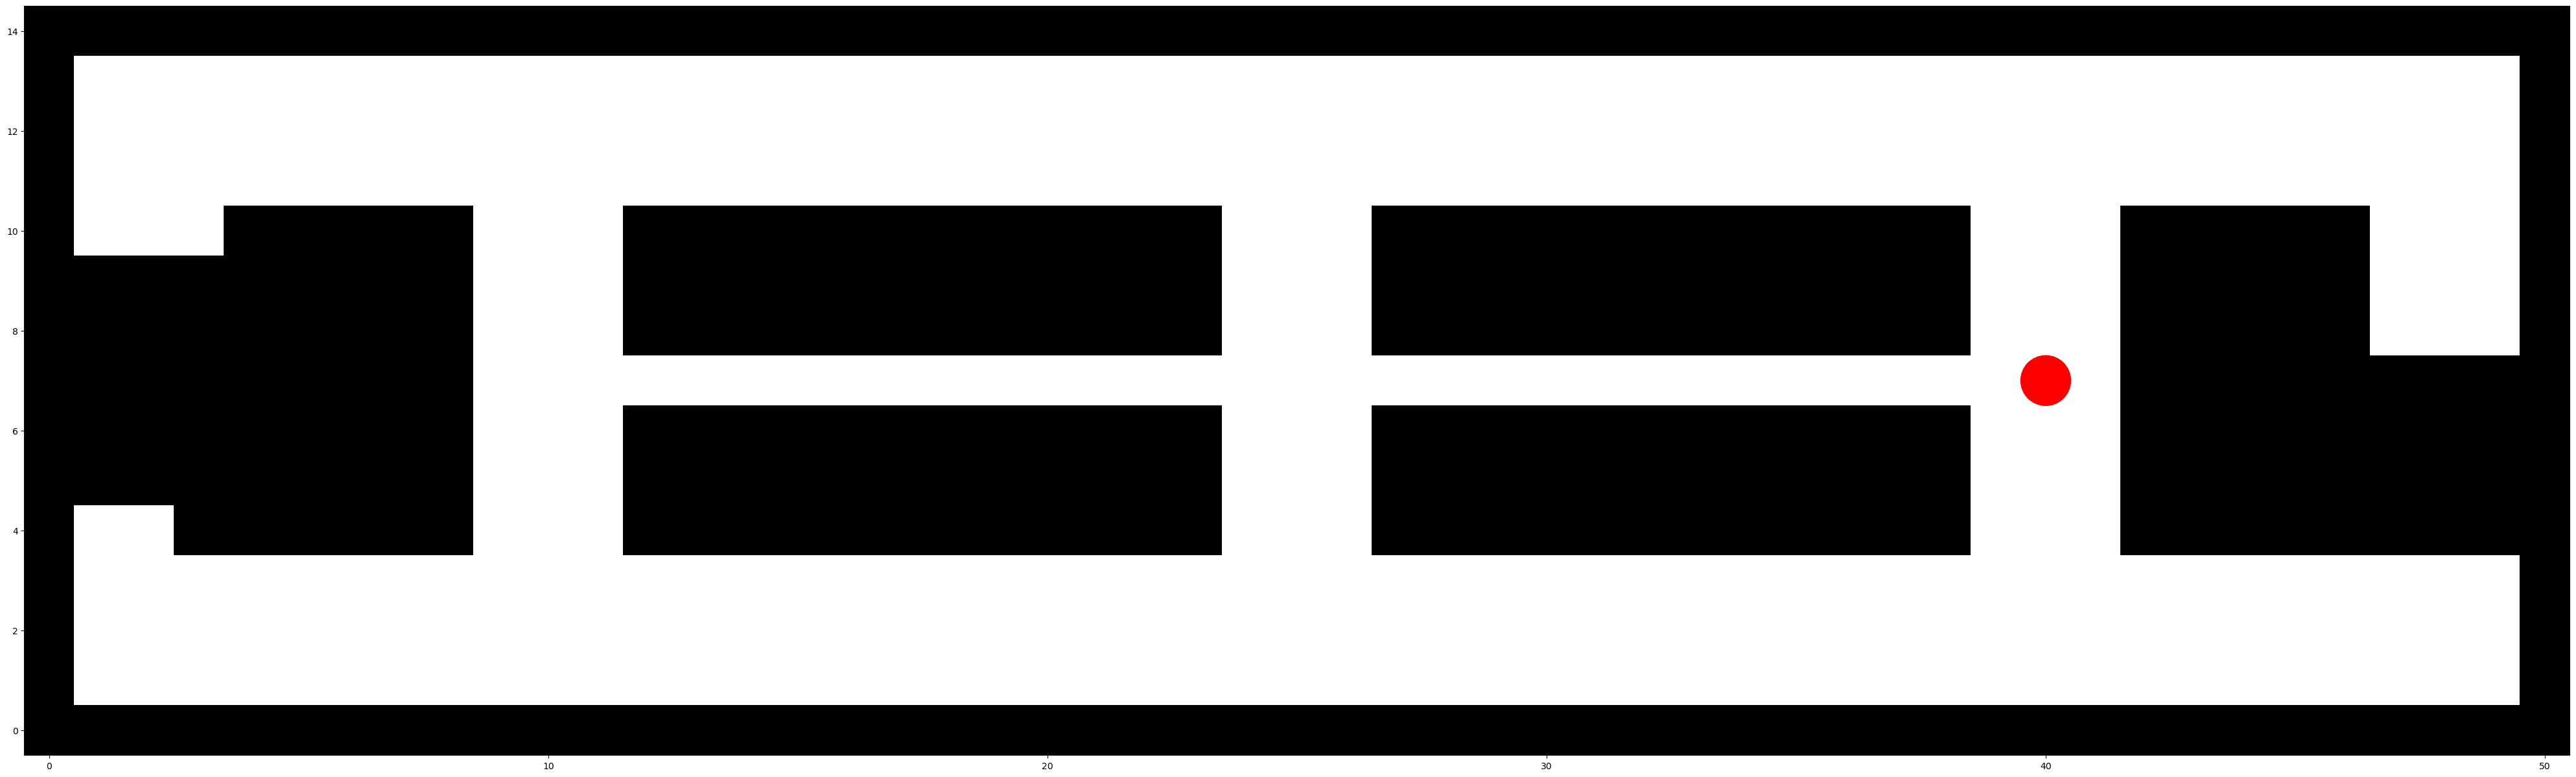

In [110]:
#Visualizamos el mapa y el destino
visualiza_mapa(mapa,destino)

In [111]:
#Generamos los estados
nav_estados = []
generar_estados(mapa)
len(nav_estados)

765

In [112]:
# Parámetros del algoritmo Montecarlo

gamma = 0.5
epocas = 5000
max_pasos = 500

politica = montecarlo(mapa,destino,gamma,epocas,max_pasos)

print("Política:")
print(politica)

Política:
{(0, 0): 'N', (0, 1): 'E', (0, 2): 'SO', (0, 3): 'esperar', (0, 4): 'N', (0, 5): 'esperar', (0, 6): 'S', (0, 7): 'N', (0, 8): 'N', (0, 9): 'E', (0, 10): 'S', (0, 11): 'esperar', (0, 12): 'esperar', (0, 13): 'NE', (0, 14): 'N', (1, 0): 'E', (1, 1): 'NE', (1, 2): 'SE', (1, 3): 'NE', (1, 4): 'SE', (1, 5): 'NE', (1, 6): 'NO', (1, 7): 'O', (1, 8): 'SO', (1, 9): 'N', (1, 10): 'NE', (1, 11): 'E', (1, 12): 'E', (1, 13): 'SE', (1, 14): 'N', (2, 0): 'NO', (2, 1): 'NE', (2, 2): 'NE', (2, 3): 'S', (2, 4): 'SO', (2, 5): 'S', (2, 6): 'O', (2, 7): 'SE', (2, 8): 'S', (2, 9): 'SE', (2, 10): 'N', (2, 11): 'NE', (2, 12): 'O', (2, 13): 'SO', (2, 14): 'O', (3, 0): 'SO', (3, 1): 'NE', (3, 2): 'SE', (3, 3): 'SE', (3, 4): 'esperar', (3, 5): 'N', (3, 6): 'NE', (3, 7): 'N', (3, 8): 'SO', (3, 9): 'SE', (3, 10): 'N', (3, 11): 'N', (3, 12): 'SE', (3, 13): 'SE', (3, 14): 'SE', (4, 0): 'O', (4, 1): 'NE', (4, 2): 'N', (4, 3): 'SE', (4, 4): 'SO', (4, 5): 'NO', (4, 6): 'esperar', (4, 7): 'SE', (4, 8): 'N', (4

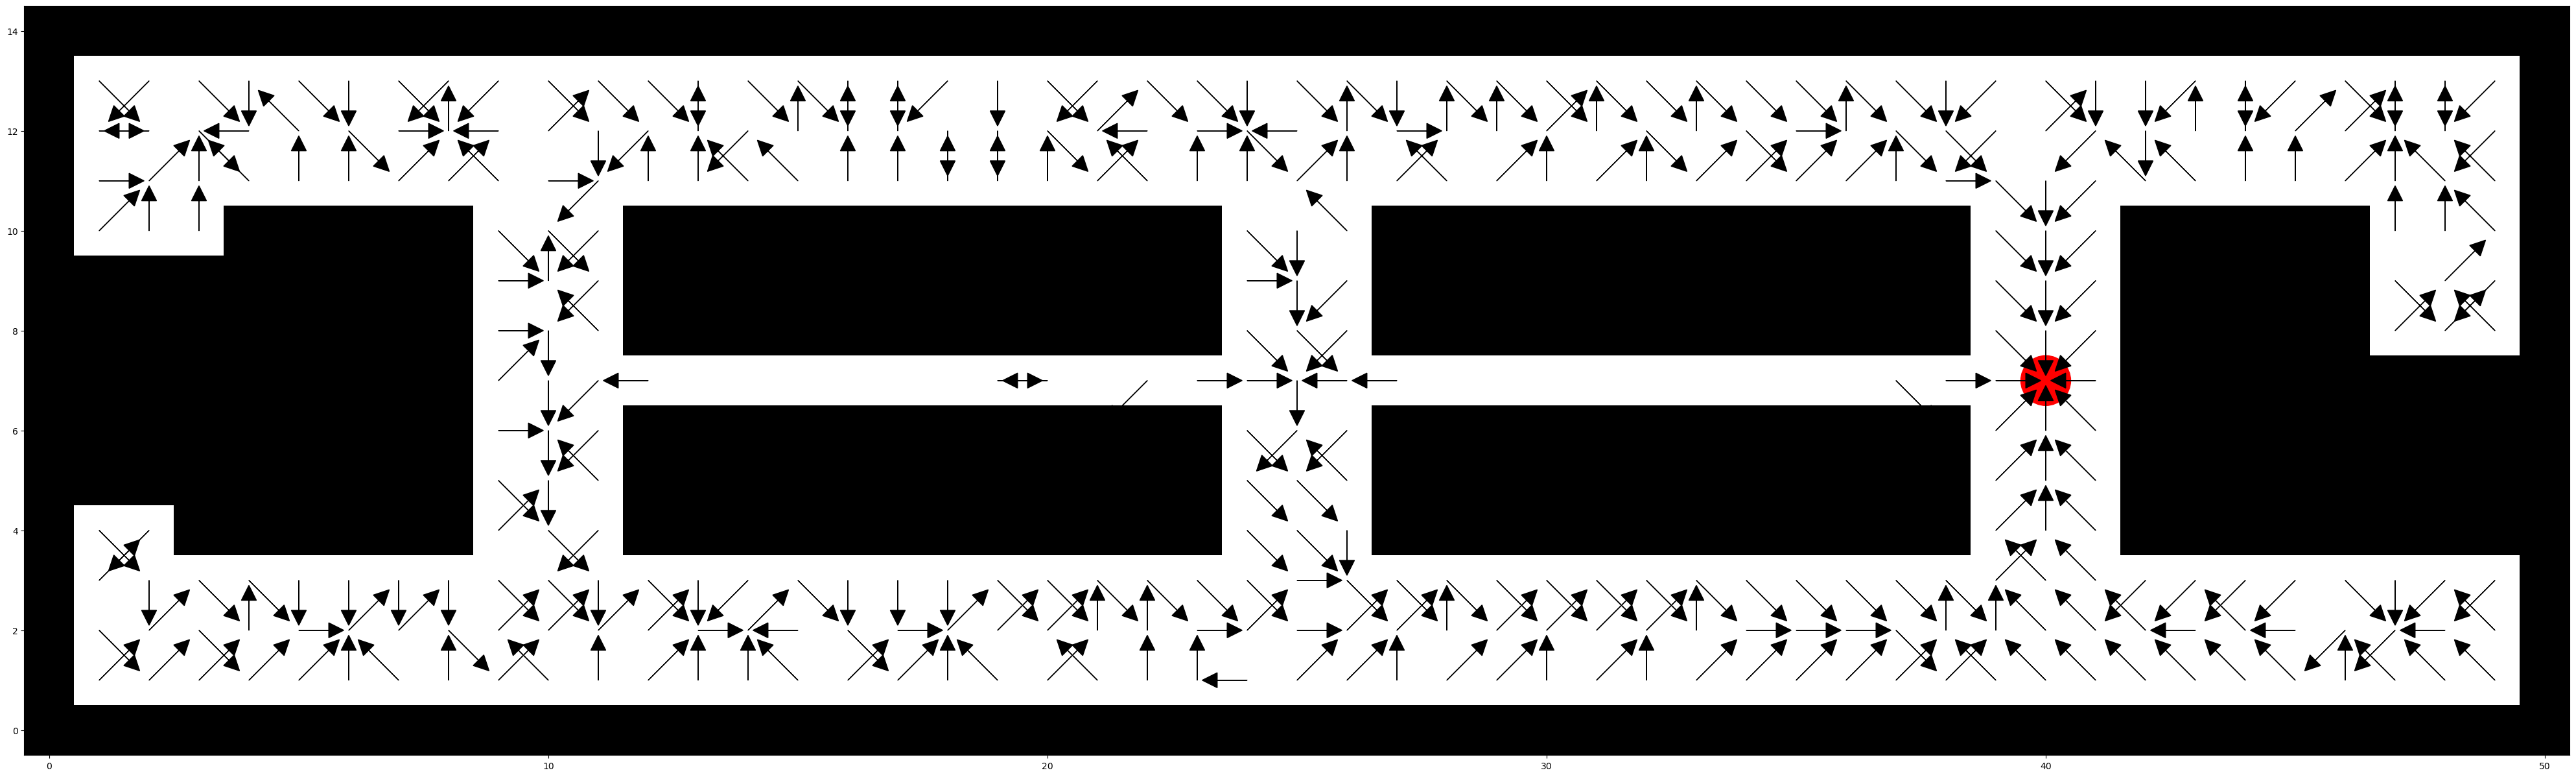

In [113]:
visualiza_politica(politica,mapa,destino)

## Mapa 2

In [114]:
# Creamos un array que almacene el mapa 
mapa,destino = lee_mapa("../../data/map2.txt")
print(mapa)
print(destino)

[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
(16.0, 3.0)


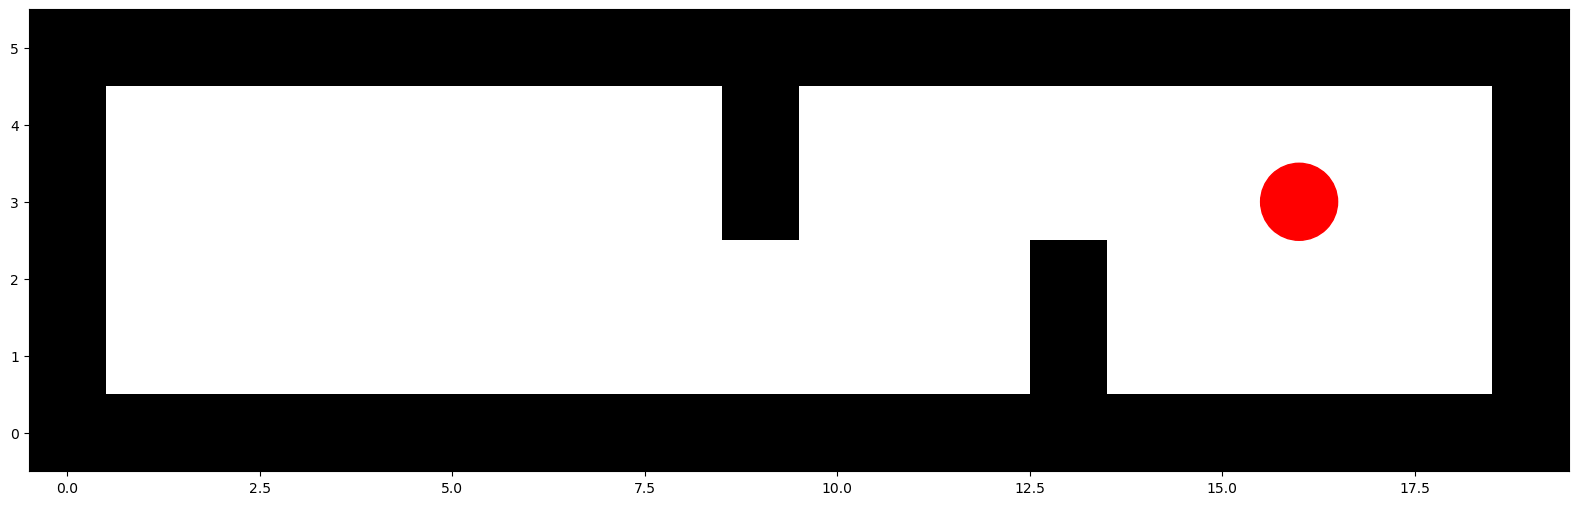

In [115]:
#Visualizamos el mapa y el destino
visualiza_mapa(mapa,destino)

In [116]:
#Generamos los estados
nav_estados = []
generar_estados(mapa)
len(nav_estados)

120

In [117]:
# Parámetros del algoritmo Montecarlo

gamma = 0.5
epocas = 5000
max_pasos = 500

politica = montecarlo(mapa,destino,gamma,epocas,max_pasos)

print("Política:")
print(politica)

Política:
{(0, 0): 'NO', (0, 1): 'esperar', (0, 2): 'esperar', (0, 3): 'esperar', (0, 4): 'esperar', (0, 5): 'esperar', (1, 0): 'esperar', (1, 1): 'NE', (1, 2): 'SE', (1, 3): 'SE', (1, 4): 'SE', (1, 5): 'esperar', (2, 0): 'esperar', (2, 1): 'NE', (2, 2): 'E', (2, 3): 'SE', (2, 4): 'SE', (2, 5): 'esperar', (3, 0): 'esperar', (3, 1): 'N', (3, 2): 'NE', (3, 3): 'SE', (3, 4): 'S', (3, 5): 'esperar', (4, 0): 'esperar', (4, 1): 'NE', (4, 2): 'NE', (4, 3): 'E', (4, 4): 'S', (4, 5): 'esperar', (5, 0): 'esperar', (5, 1): 'NE', (5, 2): 'SE', (5, 3): 'E', (5, 4): 'SE', (5, 5): 'esperar', (6, 0): 'esperar', (6, 1): 'NE', (6, 2): 'E', (6, 3): 'NE', (6, 4): 'SE', (6, 5): 'esperar', (7, 0): 'esperar', (7, 1): 'N', (7, 2): 'SE', (7, 3): 'SE', (7, 4): 'S', (7, 5): 'esperar', (8, 0): 'esperar', (8, 1): 'NE', (8, 2): 'SE', (8, 3): 'SO', (8, 4): 'SO', (8, 5): 'esperar', (9, 0): 'esperar', (9, 1): 'NE', (9, 2): 'E', (9, 3): 'esperar', (9, 4): 'esperar', (9, 5): 'esperar', (10, 0): 'esperar', (10, 1): 'NE',

Las siguientes funciones definidas son las que intervendrán en las iteraciones del algoritmo Montecarlo. La funcionalidad de cada una de ellas viene explicada con comentarios.

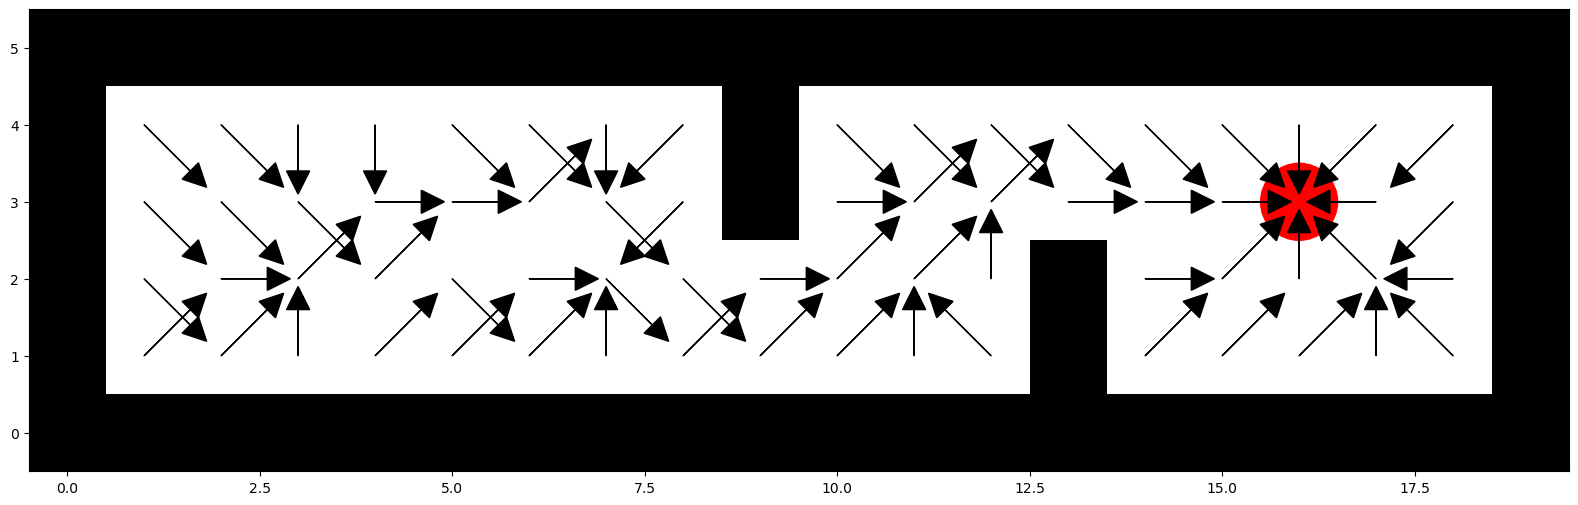

In [118]:
visualiza_politica(politica,mapa,destino)

## Mapa 3

In [119]:
# Creamos un array que almacene el mapa 
mapa,destino = lee_mapa("../../data/map3.txt")
print(mapa)
print(destino)

[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 1 1 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1]
 [1 1 0 0 1 1 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [1 1 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 1]
 [1 1 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1]
 [1 1 1 1 1 1 1 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [1 1 1 1 1 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [1 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1]
 [1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
(25.0, 3.0)


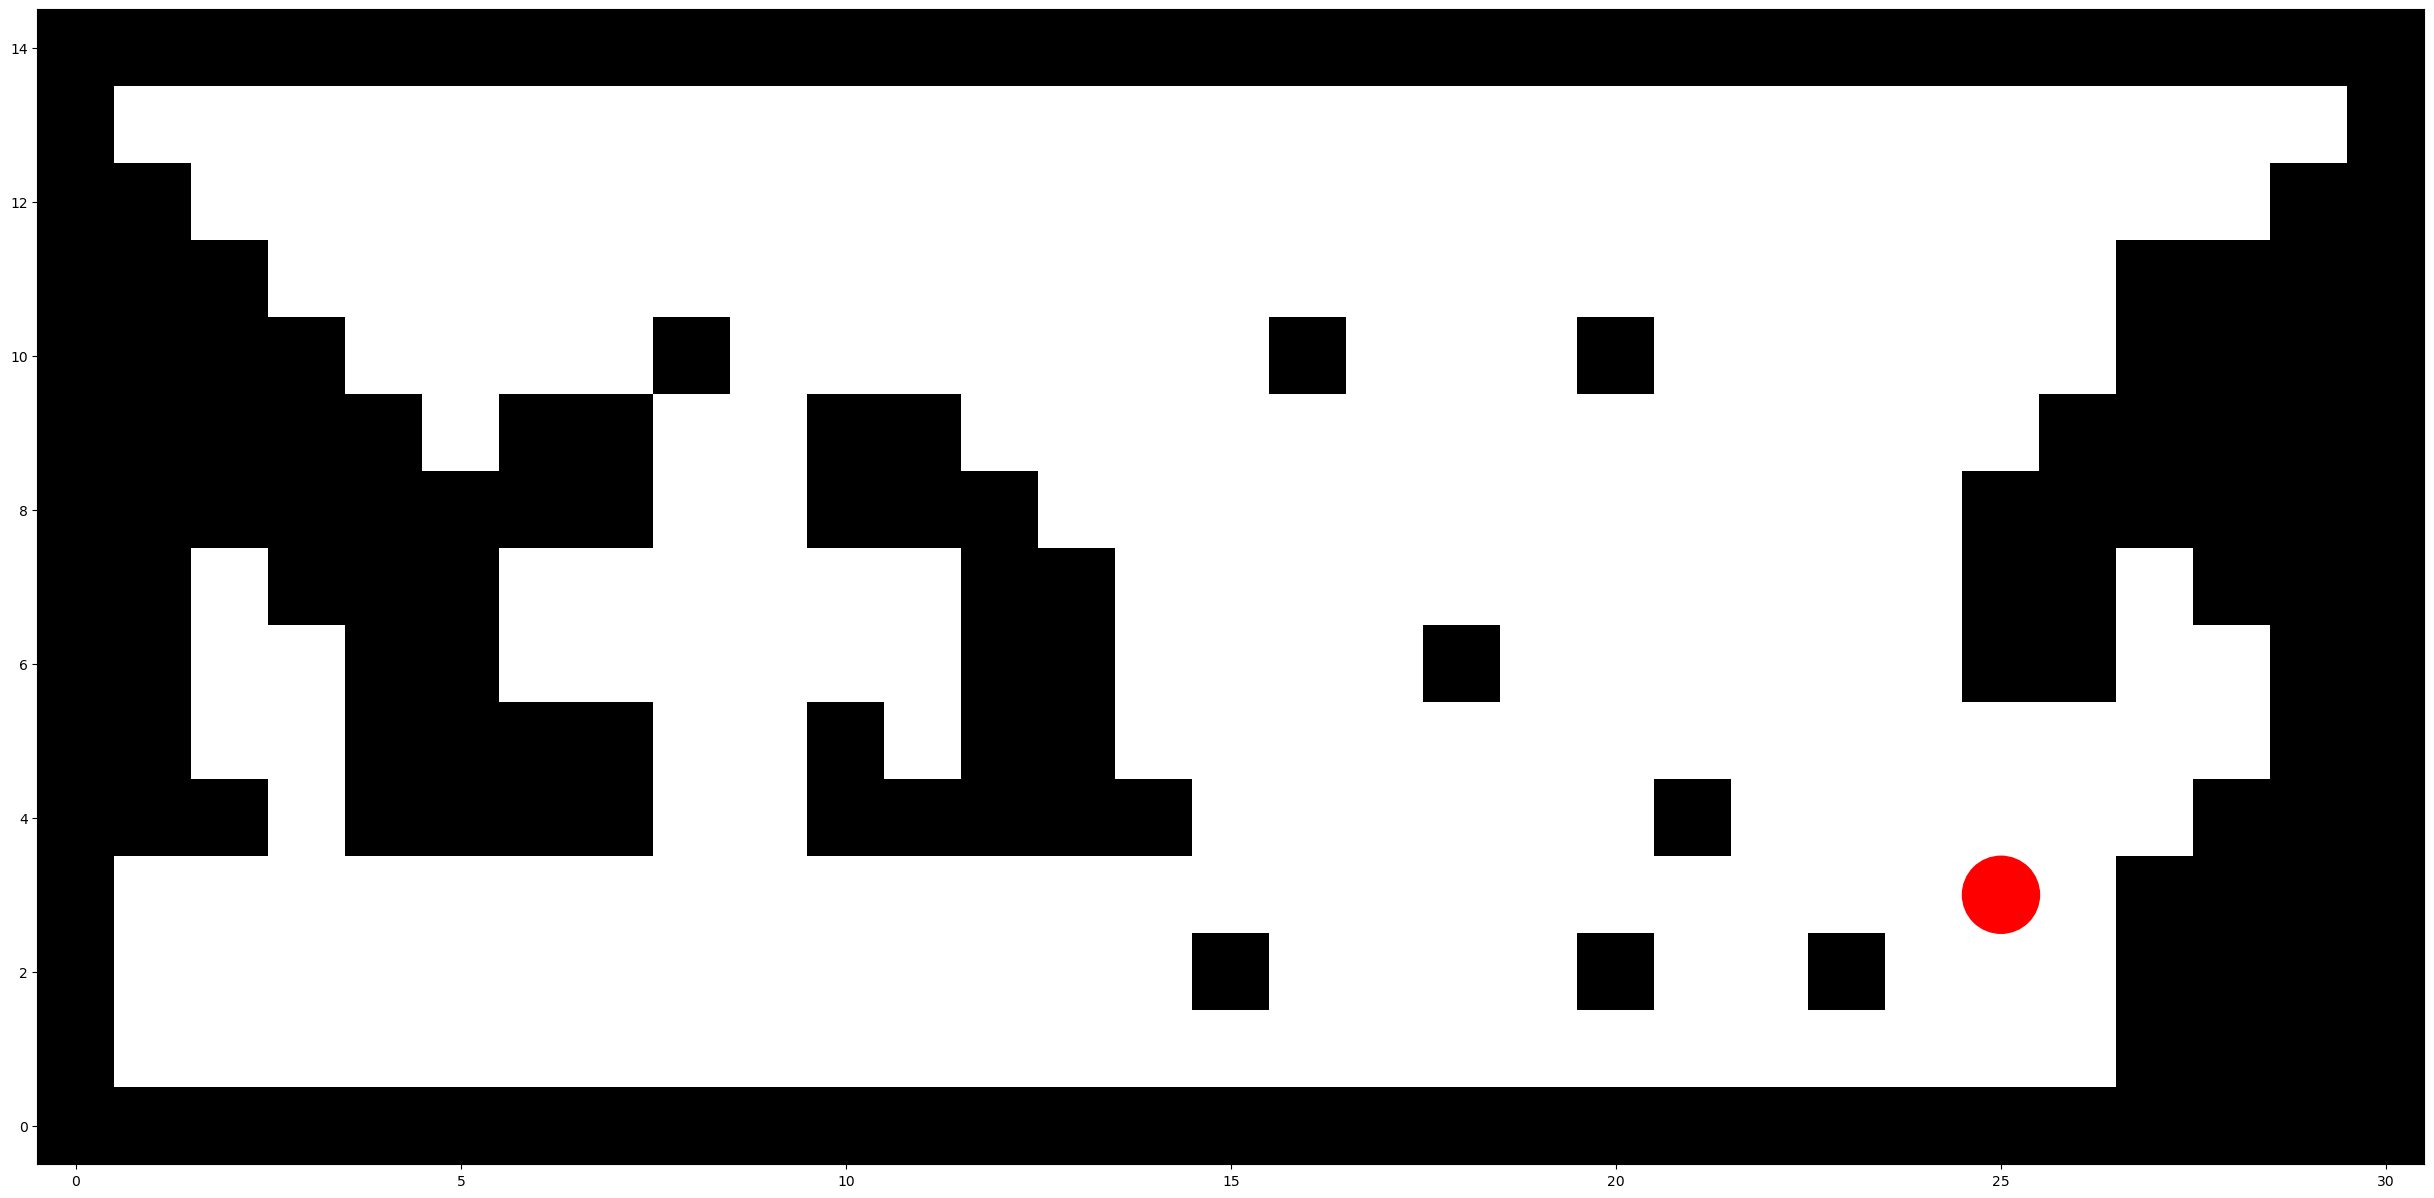

In [120]:
#Visualizamos el mapa y el destino
visualiza_mapa(mapa,destino)

In [121]:
#Generamos los estados
nav_estados = []
generar_estados(mapa)
len(nav_estados)

465

In [122]:
# Parámetros del algoritmo Montecarlo

gamma = 0.5
epocas = 5000
max_pasos = 500

politica = montecarlo(mapa,destino,gamma,epocas,max_pasos)

print("Política:")
print(politica)

Política:
{(0, 0): 'NE', (0, 1): 'NE', (0, 2): 'SO', (0, 3): 'E', (0, 4): 'E', (0, 5): 'SO', (0, 6): 'esperar', (0, 7): 'NO', (0, 8): 'E', (0, 9): 'esperar', (0, 10): 'E', (0, 11): 'O', (0, 12): 'N', (0, 13): 'N', (0, 14): 'N', (1, 0): 'E', (1, 1): 'NE', (1, 2): 'NE', (1, 3): 'SE', (1, 4): 'esperar', (1, 5): 'E', (1, 6): 'esperar', (1, 7): 'SO', (1, 8): 'SO', (1, 9): 'NE', (1, 10): 'SO', (1, 11): 'NE', (1, 12): 'esperar', (1, 13): 'esperar', (1, 14): 'E', (2, 0): 'SE', (2, 1): 'N', (2, 2): 'S', (2, 3): 'SE', (2, 4): 'esperar', (2, 5): 'E', (2, 6): 'SE', (2, 7): 'esperar', (2, 8): 'SE', (2, 9): 'SO', (2, 10): 'N', (2, 11): 'SO', (2, 12): 'NE', (2, 13): 'SE', (2, 14): 'O', (3, 0): 'SO', (3, 1): 'NO', (3, 2): 'SE', (3, 3): 'NO', (3, 4): 'S', (3, 5): 'SO', (3, 6): 'O', (3, 7): 'esperar', (3, 8): 'NE', (3, 9): 'esperar', (3, 10): 'S', (3, 11): 'NE', (3, 12): 'N', (3, 13): 'SE', (3, 14): 'esperar', (4, 0): 'O', (4, 1): 'N', (4, 2): 'O', (4, 3): 'SE', (4, 4): 'esperar', (4, 5): 'esperar', (4,

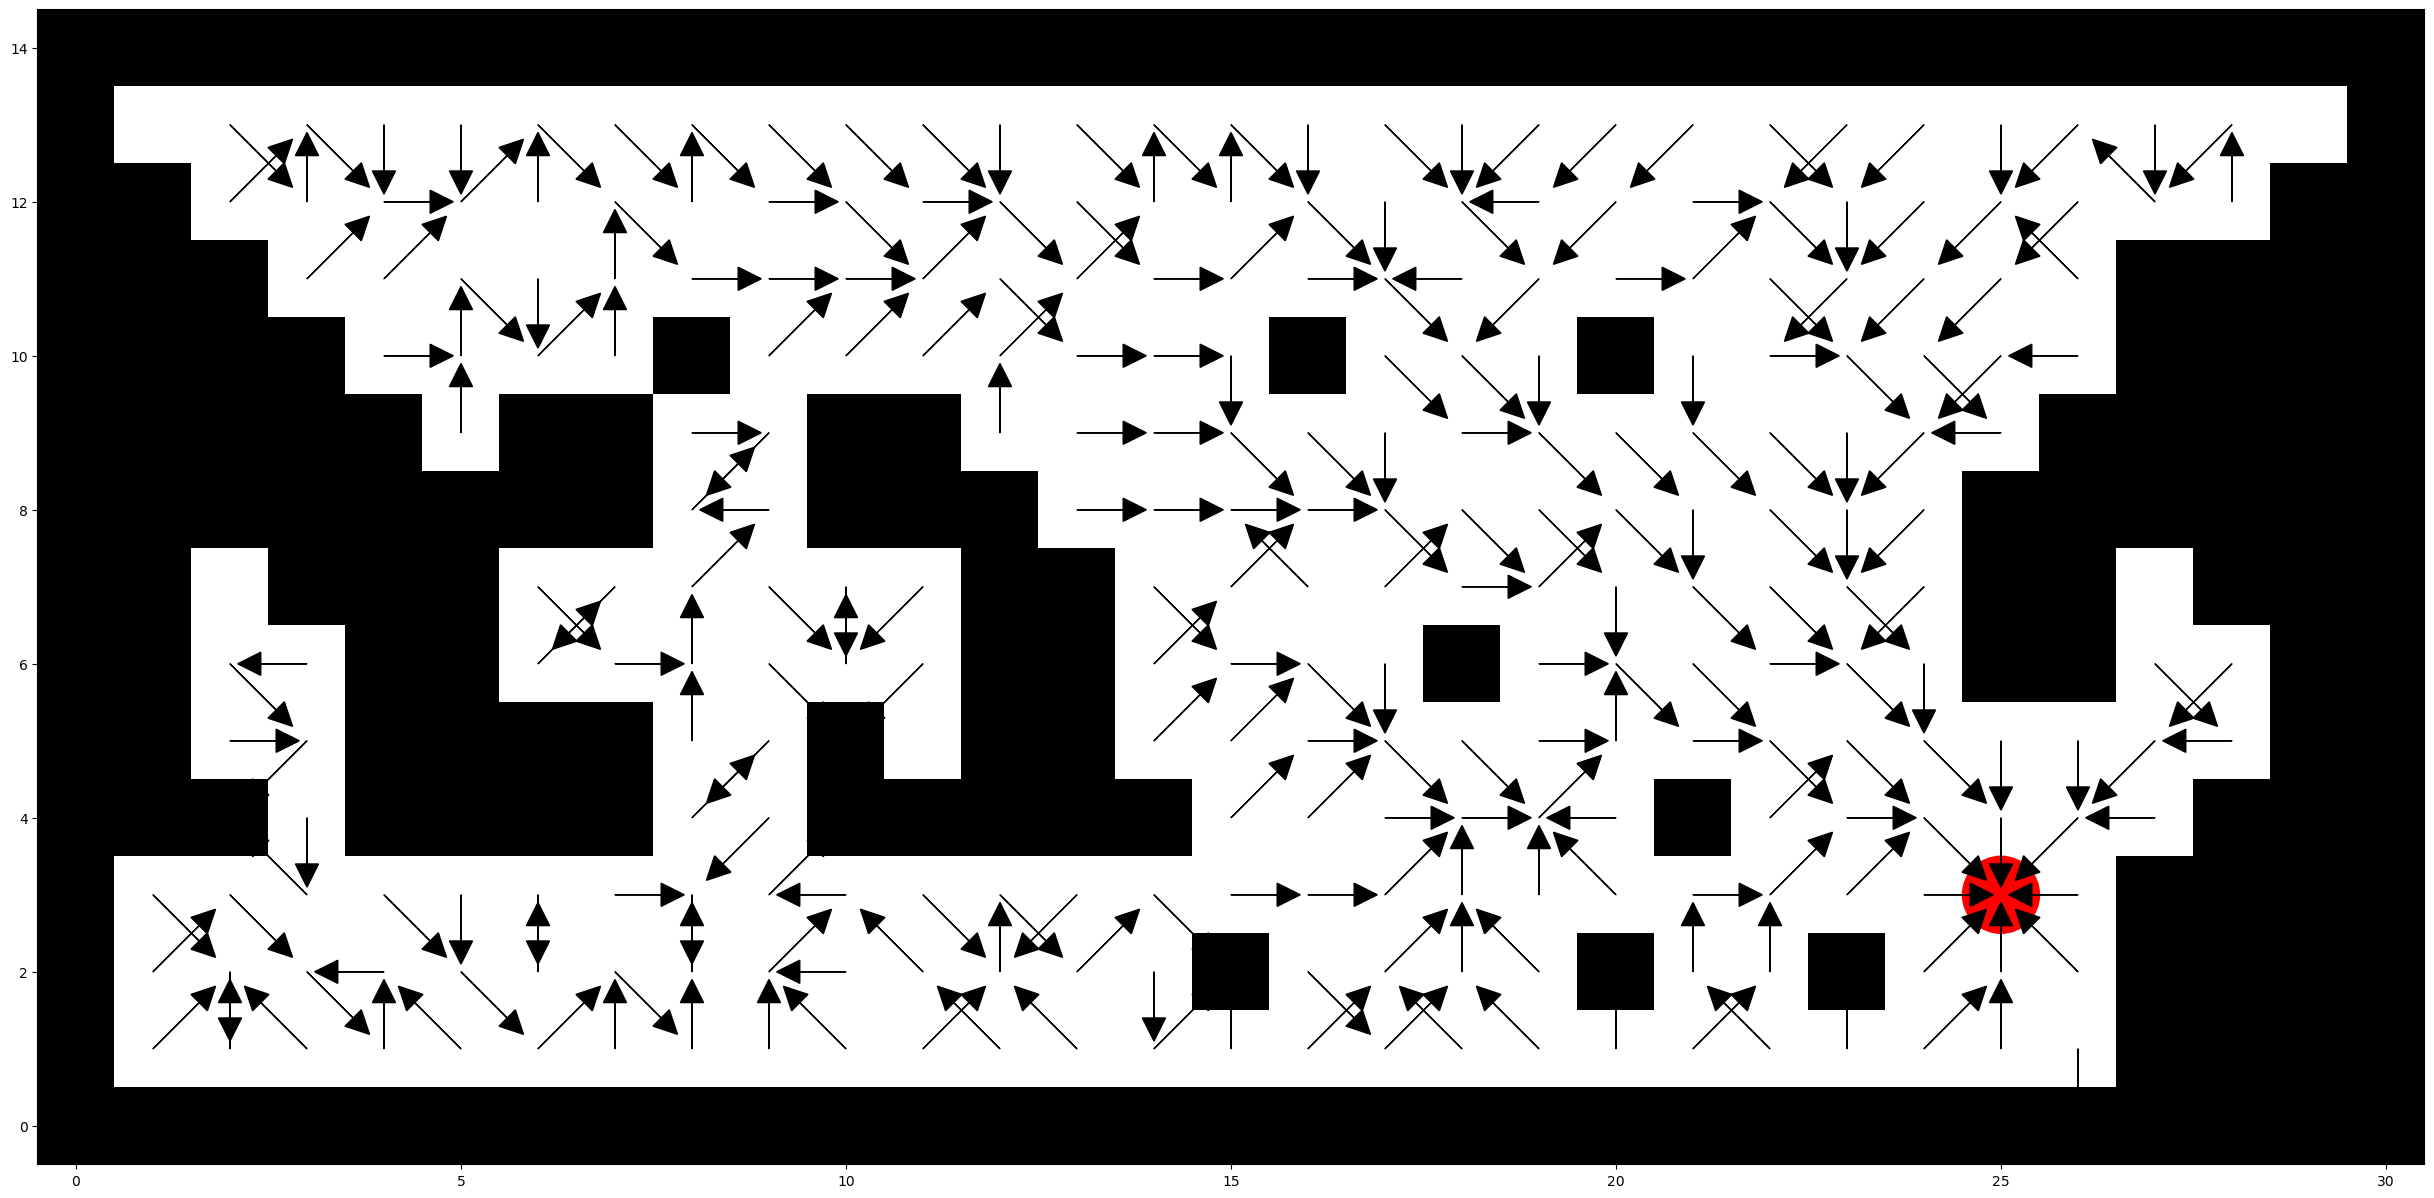

In [123]:
visualiza_politica(politica,mapa,destino)